### Importing Libraries

In [14]:
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os, requests
import tarfile
%matplotlib inline

### Getting data and setting parameters

In [2]:
N_SUBJECTS = 100
N_PARCELS = 360
TR = 0.72
HEMIS = ["Right", "Left"]
RUNS   = ['LR','RL']
N_RUNS = 2
EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win','neut']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}
fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"
if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
HCP_DIR = "./hcp_task"
if not os.path.exists(HCP_DIR):
    with tarfile.open(fname) as tfile:
      tfile.extractall('.')
subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

### Helper functions to load fMRI data, create HRF and then create design matrix

In [3]:
def load_single_timeseries(subject, experiment, run):
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  ts -= ts.mean(axis=1, keepdims=True)
  ts /= ts.std(axis=1, keepdims=True)
  return ts.T

def create_hrf(tr, oversampling=16, time_length=32, onset=0):
    dt = tr / oversampling
    time_stamps = np.linspace(onset, time_length, int(time_length / dt))
    peak_delay = 6
    undershoot_delay = 16
    peak_disp = 1
    undershoot_disp = 1
    peak_scale = 1
    undershoot_scale = 0.25
    peak = gamma.pdf(time_stamps, peak_delay / peak_disp, loc=onset, scale=peak_disp)
    undershoot = gamma.pdf(time_stamps, undershoot_delay / undershoot_disp, loc=onset, scale=undershoot_disp)
    hrf = peak_scale * peak - undershoot_scale * undershoot
    hrf /= hrf.max()
    return hrf

def create_design_matrix(subject, experiment, run, TR, n_scans):
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    events_data = []
    EXPERIMENTS[experiment]['cond']  = ["loss", "win", "neut"]
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}_event.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        df = pd.DataFrame({
            'onset': ev_array[0],
            'duration': ev_array[1],
            'amplitude': ev_array[2],
            'trial_type': cond
        })
        events_data.append(df)
    events = pd.concat(events_data, ignore_index=True)
    events = events.sort_values('onset')
    frame_times = np.arange(n_scans) * TR
    hrf = create_hrf(TR)
    design_matrix = np.zeros((n_scans, len(EXPERIMENTS[experiment]['cond'])))
    for i, cond in enumerate(EXPERIMENTS[experiment]['cond']):
        cond_events = events[events['trial_type'] == cond]
        regressor = np.zeros(n_scans)
        for _, event in cond_events.iterrows():
            onset = int(event['onset'] / TR)
            duration = int(event['duration'] / TR)
            amplitude = event['amplitude']
            regressor[onset:onset+duration] = amplitude
        convolved_regressor = np.convolve(regressor, hrf)[:n_scans]
        design_matrix[:, i] = convolved_regressor
    design_matrix = np.column_stack([np.ones(n_scans), design_matrix])
    column_names = ['constant'] + EXPERIMENTS[experiment]['cond']
    design_matrix_df = pd.DataFrame(design_matrix, columns=column_names)
    return design_matrix_df

### Getting a sample fMRI timeseries and creating its design matrix

In [4]:
subject = subjects[0]
experiment = 'GAMBLING'
run = 0
TR = 0.72
n_scans = 253

bold_data = load_single_timeseries(subjects[0], "GAMBLING", 0)
design_matrix = create_design_matrix(subjects[0], "GAMBLING", 0, 0.72, 253)

### Visualising the design matrix

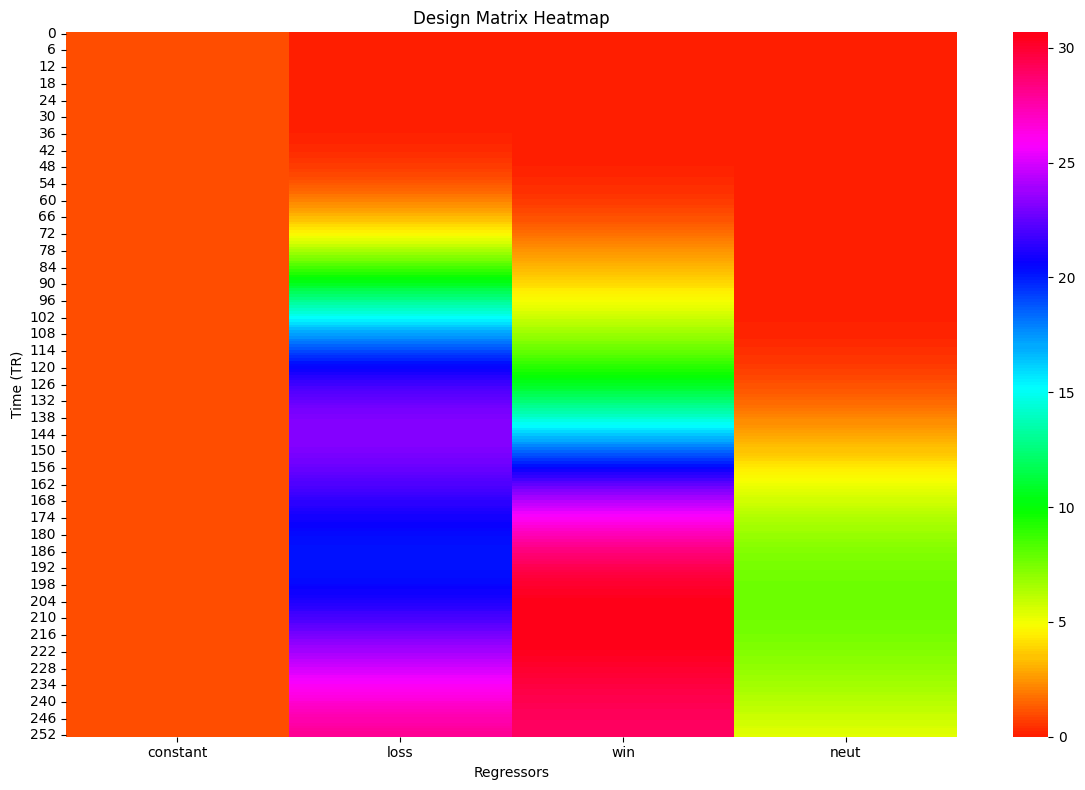

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(design_matrix, cmap='hsv', center=15)
plt.title('Design Matrix Heatmap')
plt.xlabel('Regressors')
plt.ylabel('Time (TR)')
plt.tight_layout()
plt.show()

### Doing First level GLM for one subject across each ROI independently

In [6]:
results = []

for roi in range(360):
    model = sm.OLS(bold_data[:, roi], design_matrix).fit()
    results.append({
        'ROI': roi,
        'coefficients': np.array(model.params),
        'p_values': np.array(model.pvalues),
        't_values': np.array(model.tvalues),
        'rsquared': model.rsquared
    })

results_df = pd.DataFrame(results)

### Visualizing Coefficient of regression for each ROI

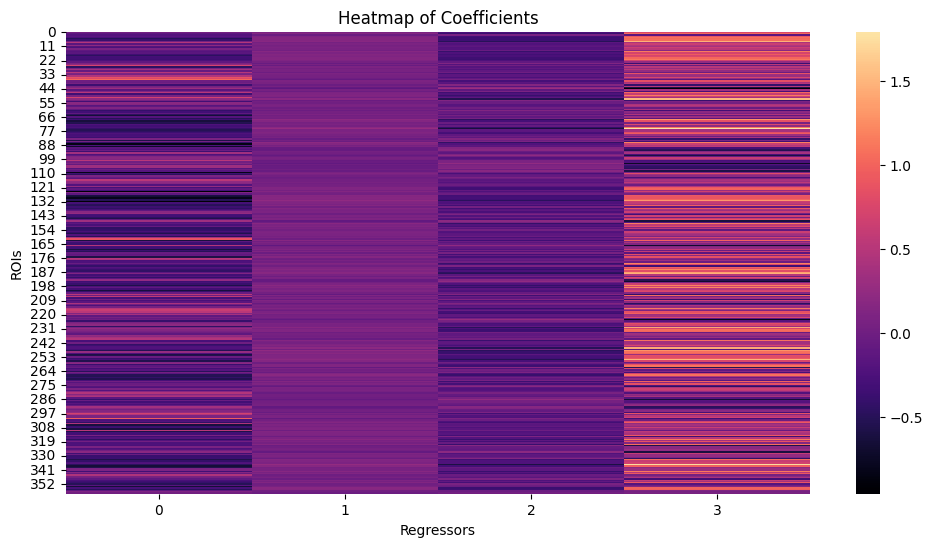

In [17]:
coefficients_matrix = np.stack(results_df['coefficients'].values)
plt.figure(figsize=(12, 6))
sns.heatmap(coefficients_matrix, annot=False, cmap='magma', center=0.5)
plt.title('Heatmap of Coefficients')
plt.xlabel('Regressors')
plt.ylabel('ROIs')
plt.show()

### Visualizing p-values per regressor for each ROI

We see lots of significant results which might occur because of comparing across 360 ROIs.

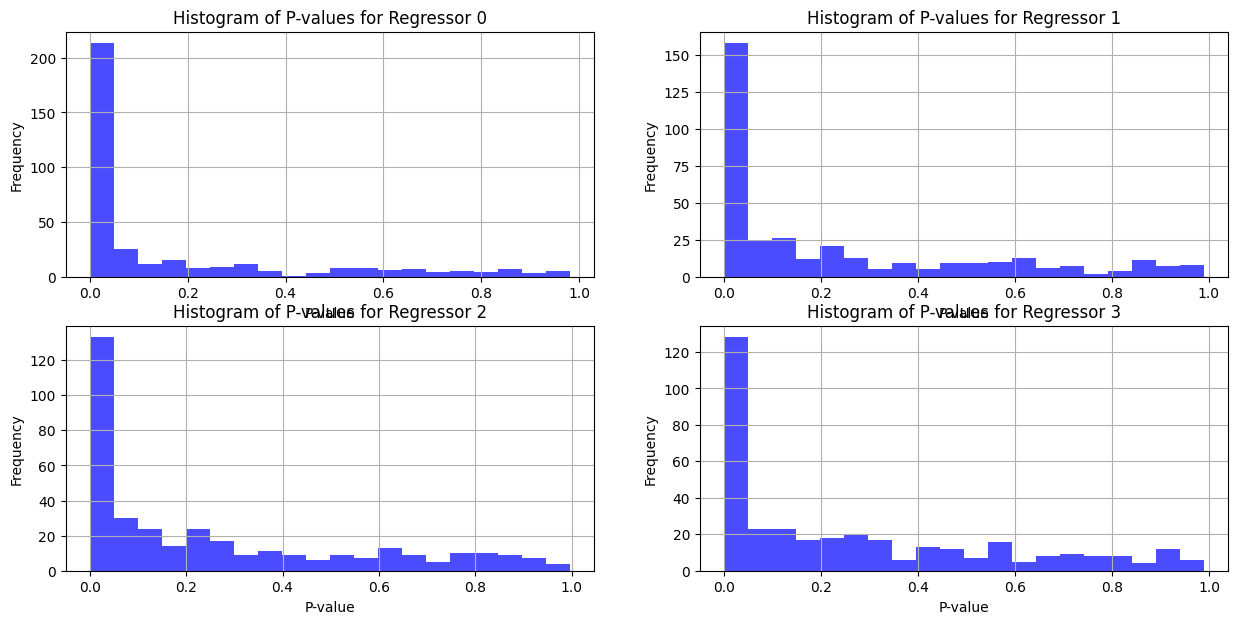

In [12]:
p_values_matrix = np.stack(results_df['p_values'].values)
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].hist(p_values_matrix[:, i], bins=20, alpha=0.7, color='blue')
    axs[i].set_title(f'Histogram of P-values for Regressor {i}')
    axs[i].set_xlabel('P-value')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

### Applying Benjamini-Hochberg Correction to p-values

Number of significant results drops somewhat for each ROI

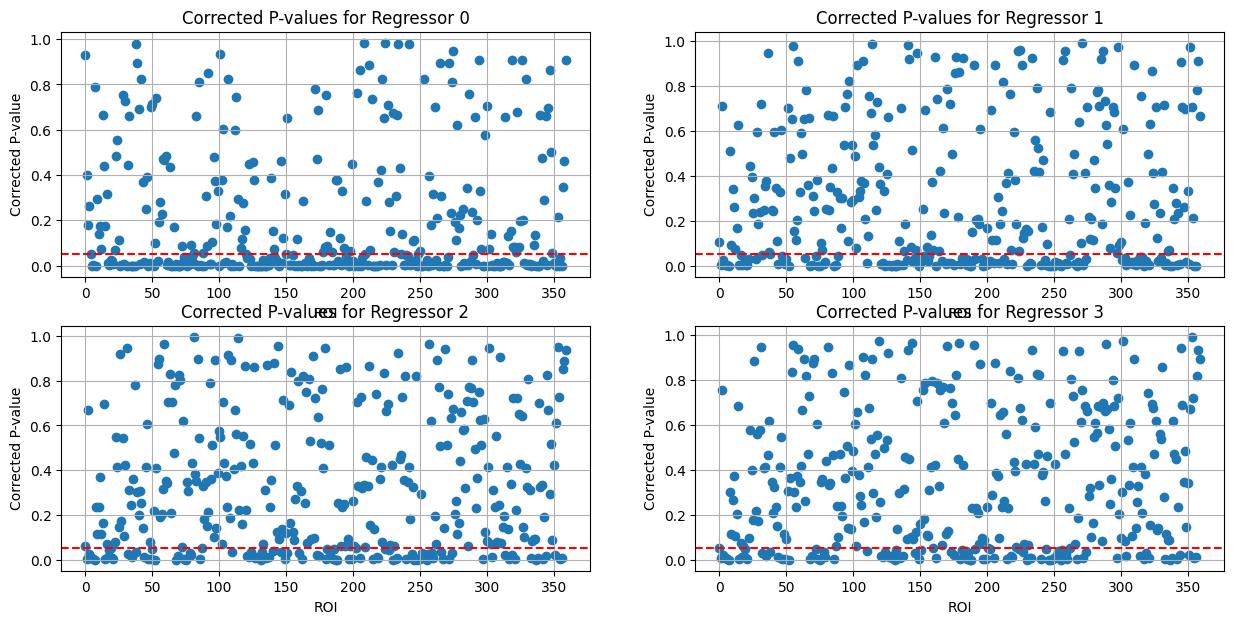

In [24]:
p_values_flat = p_values_matrix.flatten()
corrected_p_values = multipletests(p_values_flat, alpha=0.05, method='fdr_bh')[1]
corrected_p_values_matrix = corrected_p_values.reshape(360, p_values_matrix.shape[1])

fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(results_df['ROI'], corrected_p_values_matrix[:, i])
    axs[i].axhline(y=0.05, color='r', linestyle='--')
    axs[i].set_title(f'Corrected P-values for Regressor {i}')
    axs[i].set_xlabel('ROI')
    axs[i].set_ylabel('Corrected P-value')
    axs[i].grid(True)

### Applying Bonferroni Correction to p-values

Number of significant results drops by a lot for each ROI

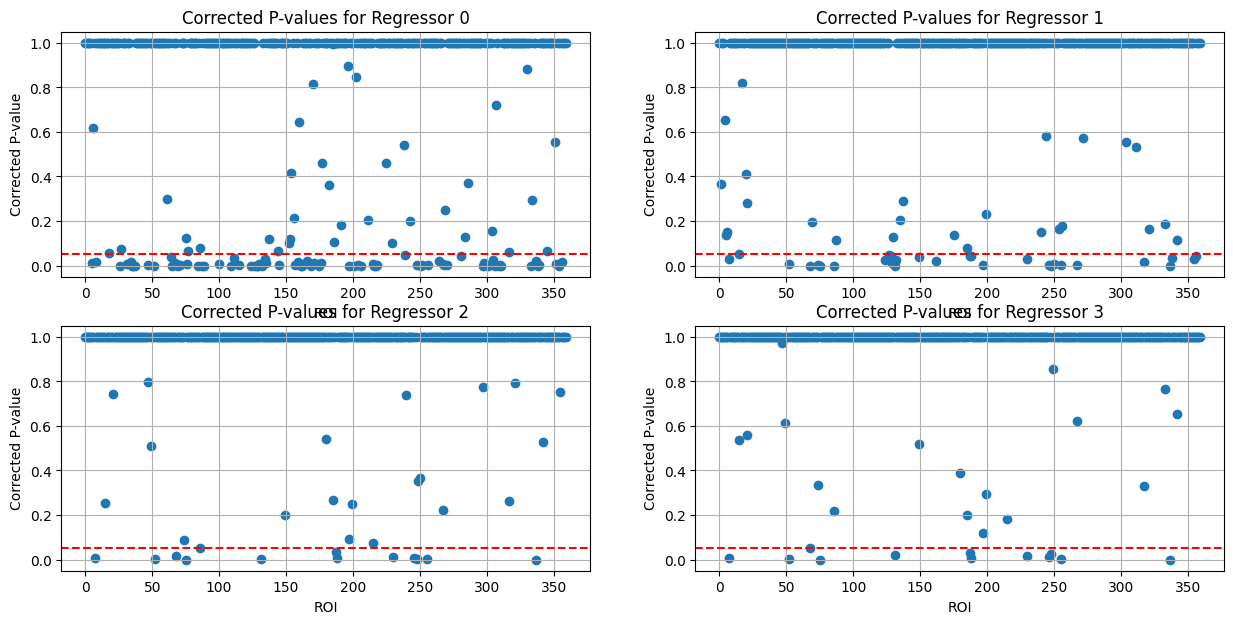

In [25]:
p_values_flat = p_values_matrix.flatten()
corrected_p_values = multipletests(p_values_flat, alpha=0.05, method='bonferroni')[1]
corrected_p_values_matrix = corrected_p_values.reshape(360, p_values_matrix.shape[1])

fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(results_df['ROI'], corrected_p_values_matrix[:, i])
    axs[i].axhline(y=0.05, color='r', linestyle='--')
    axs[i].set_title(f'Corrected P-values for Regressor {i}')
    axs[i].set_xlabel('ROI')
    axs[i].set_ylabel('Corrected P-value')
    axs[i].grid(True)

### Visualising R_squared across ROIs

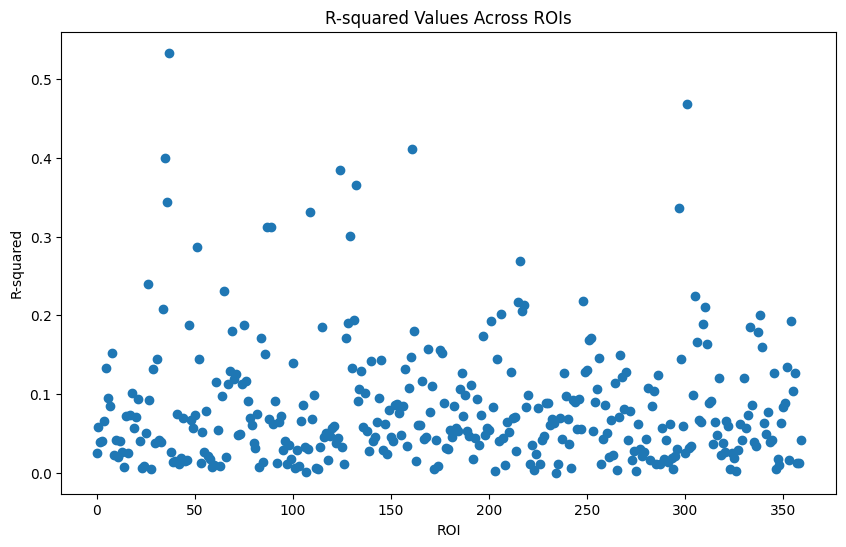

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['ROI'], results_df['rsquared'])
plt.title('R-squared Values Across ROIs')
plt.xlabel('ROI')
plt.ylabel('R-squared')
plt.show()